In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [2]:

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = "cpu"
print(f"Using device = {device}")

Using device = cpu


In [3]:
n_samples = 1000
X,y = make_circles(n_samples=1000, noise = 0.03, random_state=42)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (1000, 2)
Shape of y: (1000,)


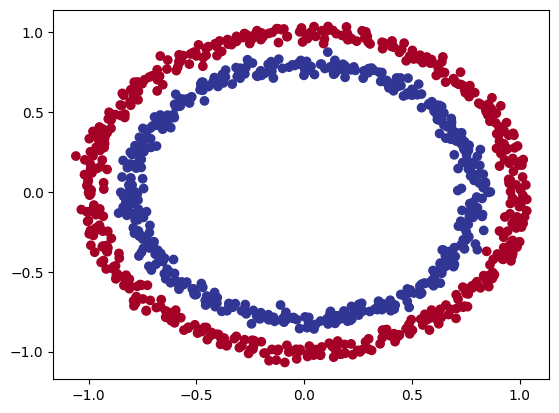

In [4]:
plt.scatter(X[:,0], X[:,1], c=y, cmap = 'RdYlBu')

In [5]:
X,y = torch.from_numpy(X).type(torch.float), torch.from_numpy(y).type(torch.float)
print("type of x:",type(X))
print("type of y:",type(y))

type of x: <class 'torch.Tensor'>
type of y: <class 'torch.Tensor'>


In [6]:
#splitting the training and testing dataset
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

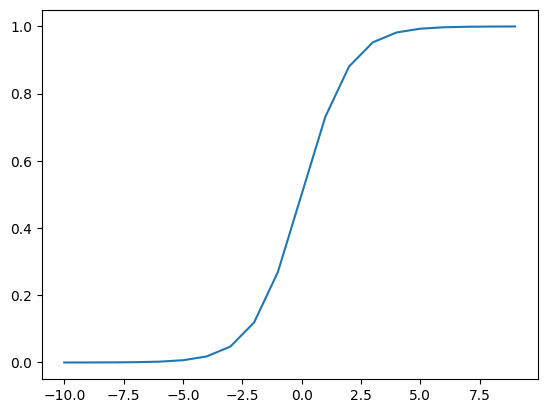

In [7]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

demo_x= range(-10, 10)
demo_y = [sigmoid(val) for val in demo_x]

plt.plot(demo_x, demo_y)


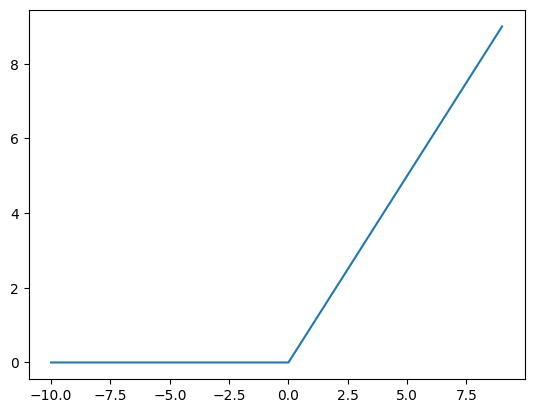

In [8]:
def relu(x):
    if x<=0:
        return 0
    else:
        return x


demo_x = range(-10, 10)
demo_y = [relu(val) for val in demo_x]

plt.plot(demo_x, demo_y)

In [9]:
class CircleClassifier(nn.Module):
    def __init__(self ,input_features,output_features, hidden_features=10):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_features)
        self.layer2 = nn.Linear(in_features=hidden_features,
                               out_features=hidden_features)
        self.layer3 = nn.Linear(in_features=hidden_features,
                               out_features=output_features)
        self.relu = nn.ReLU()

    def forward(self, x:torch.Tensor)->torch.Tensor:
        x=self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))

        return self.layer3(x)

In [10]:
model_1 = CircleClassifier(input_features=2, output_features=1)
model_1.to(device)
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.3091, -0.5307],
                      [-0.5283,  0.1971],
                      [-0.0107, -0.1056],
                      [ 0.6971, -0.3556],
                      [-0.0502, -0.5953],
                      [ 0.1953, -0.4729],
                      [-0.0148, -0.6859],
                      [-0.4467,  0.1318],
                      [ 0.5739,  0.6395],
                      [-0.3246, -0.3549]])),
             ('layer1.bias',
              tensor([ 0.6913, -0.3067, -0.1124, -0.3817, -0.2901, -0.5628, -0.2656,  0.5784,
                       0.2697,  0.5319])),
             ('layer2.weight',
              tensor([[-0.1952, -0.2916, -0.1128, -0.1381,  0.2863, -0.1507,  0.0767, -0.0147,
                        0.1885,  0.2794],
                      [-0.1027,  0.1538, -0.0790,  0.0826, -0.1124, -0.0628, -0.0186,  0.0294,
                       -0.0038, -0.2815],
                      [-0.2800, -0.2702,  0.3014,  0.3095,  0.0355,  0.2808

In [11]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [12]:
from numpy import argmax


def accuracy_fn(y_true, y_pred):
    if y_pred.dim() == 1:  # Binary classification
        # Convert probabilities/logits to 0 or 1
        y_pred = (y_pred > 0.5).long()
    else:  # Multi-class classification
        y_pred = y_pred.argmax(dim=1)

    correct = (y_true == y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

In [13]:
from tqdm import tqdm 
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
trainLossList = []
testLossList = []
for epoch in range(epochs):
    #training
    model_1.train()

    #forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    #compute loss
    loss = loss_fn(y_logits, y_train)
    
    #zero grad optimizer
    optimizer.zero_grad()

    #back propagate
    loss.backward()

    #step the optimizer
    optimizer.step()
    # print(f"y_true shape: {y_train.shape}, y_pred shape: {y_pred.shape}")


    accuracy = accuracy_fn(y_true = y_train, y_pred=y_pred)

    #testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss  = loss_fn(test_logits, test_pred)
        test_accuracy = accuracy_fn(y_true = y_test, y_pred=test_pred)

    if(epoch%10==0):
        print(f"Epoch: {epoch}| Train Loss: {loss:.4f}| Train Acc: {accuracy}| Test Loss: {test_loss:.4f}| Test Acc: {test_accuracy:.4f}")
    
    trainLossList.append(loss.cpu().detach().numpy())
    testLossList.append(test_loss.cpu().detach().numpy())

Epoch: 0| Train Loss: 0.6918| Train Acc: 62.375| Test Loss: 0.6544| Test Acc: 58.5000
Epoch: 10| Train Loss: 0.6911| Train Acc: 54.87499999999999| Test Loss: 0.6617| Test Acc: 55.5000
Epoch: 20| Train Loss: 0.6906| Train Acc: 54.50000000000001| Test Loss: 0.6646| Test Acc: 55.0000
Epoch: 30| Train Loss: 0.6902| Train Acc: 55.875| Test Loss: 0.6656| Test Acc: 58.5000
Epoch: 40| Train Loss: 0.6899| Train Acc: 56.875| Test Loss: 0.6657| Test Acc: 57.5000
Epoch: 50| Train Loss: 0.6896| Train Acc: 55.50000000000001| Test Loss: 0.6655| Test Acc: 56.5000
Epoch: 60| Train Loss: 0.6893| Train Acc: 54.0| Test Loss: 0.6651| Test Acc: 56.0000
Epoch: 70| Train Loss: 0.6890| Train Acc: 53.87499999999999| Test Loss: 0.6646| Test Acc: 53.5000
Epoch: 80| Train Loss: 0.6888| Train Acc: 53.87499999999999| Test Loss: 0.6641| Test Acc: 53.0000
Epoch: 90| Train Loss: 0.6885| Train Acc: 53.87499999999999| Test Loss: 0.6635| Test Acc: 52.5000
Epoch: 100| Train Loss: 0.6882| Train Acc: 54.0| Test Loss: 0.6629|

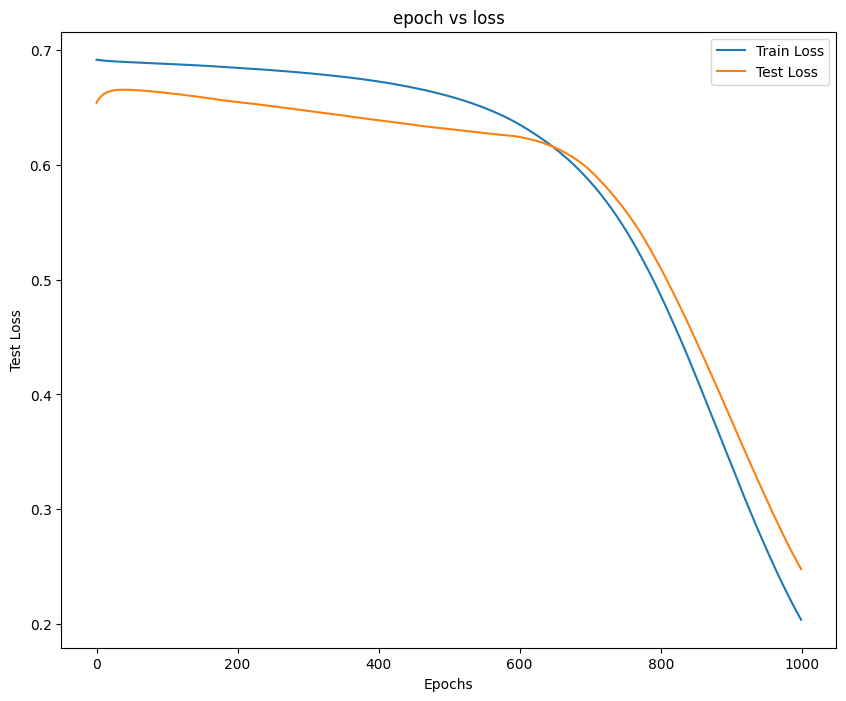

In [14]:
plt.figure(figsize=(10,8))
plt.plot(trainLossList, label="Train Loss")
plt.plot(testLossList, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel('Test Loss')
plt.title('epoch vs loss')
plt.legend()

In [15]:

model_1.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_1(X_test))).squeeze()
print(y_preds)

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.])


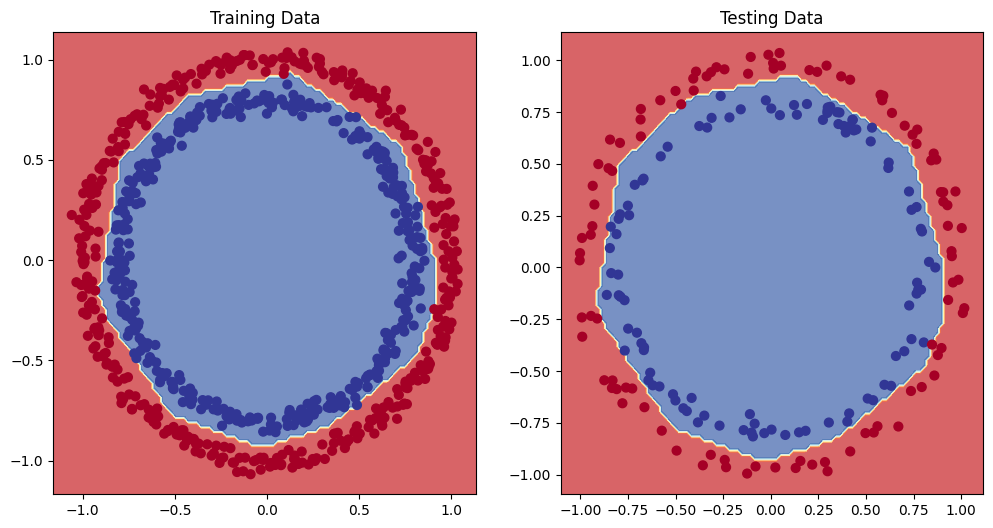

In [16]:

from helper_functions import plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training Data")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing Data")
plot_decision_boundary(model_1, X_test, y_test)